In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


2024-07-17 12:12:23.240 | DEBUG    | incision_detection_mmdet:<module>:19 - 1.12.0a0+8a1a93a
2024-07-17 12:12:23.242 | DEBUG    | incision_detection_mmdet:<module>:24 - mmdet.version=2.25.0
2024-07-17 12:12:23.242 | DEBUG    | incision_detection_mmdet:<module>:29 - 11.7
2024-07-17 12:12:23.243 | DEBUG    | incision_detection_mmdet:<module>:30 - GCC 9.4
2024-07-17 12:12:23.760 | DEBUG    | pigleg_cv:<module>:60 - DEVICE=cuda:0


In [2]:
!pwd

/webapps/piglegsurgery/piglegcv


In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Wed Jul 17 12:12:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:0B:00.0 Off |                  N/A |
|  0%   54C    P8             16W /  165W |      18MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
torch.__version__

'1.12.0a0+8a1a93a'

In [6]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

False

In [7]:
!ls ~/.cache/torch/hub/checkpoints/

ls: cannot access '/home/appuser/.cache/torch/hub/checkpoints/': No such file or directory


In [8]:
# pip install mmcv-full

In [9]:
import logging
import mmcv

# logger = logging.getLogger(name='torch')
# logger.setLevel(logging.WARNING)

# print(logging.root.manager.loggerDict)

# loggers = [logging.getLogger(name=name).setLevel(logging.WARNING) for name in logging.root.manager.loggerDict]
# loggers



In [10]:
loggers = [logging.getLogger(name=name) for name in logging.root.manager.loggerDict]

In [11]:
loggers

[<Logger concurrent.futures (WARNING)>,
 <Logger concurrent (WARNING)>,
 <Logger asyncio (WARNING)>,
 <Logger tornado.access (WARNING)>,
 <Logger tornado (WARNING)>,
 <Logger tornado.application (WARNING)>,
 <Logger tornado.general (WARNING)>,
 <Logger prompt_toolkit.buffer (WARNING)>,
 <Logger prompt_toolkit (WARNING)>,
 <Logger parso.python.diff (WARNING)>,
 <Logger parso.python (WARNING)>,
 <Logger parso (WARNING)>,
 <Logger parso.cache (WARNING)>,
 <Logger pkg_resources.extern.packaging.tags (WARNING)>,
 <Logger pkg_resources.extern.packaging (WARNING)>,
 <Logger pkg_resources.extern (WARNING)>,
 <Logger pkg_resources (WARNING)>,
 <Logger IPKernelApp (DEBUG)>,
 <Logger urllib3.util.retry (WARNING)>,
 <Logger urllib3.util (WARNING)>,
 <Logger urllib3 (WARNING)>,
 <Logger urllib3.connection (WARNING)>,
 <Logger urllib3.response (WARNING)>,
 <Logger urllib3.connectionpool (WARNING)>,
 <Logger urllib3.poolmanager (WARNING)>,
 <Logger charset_normalizer (WARNING)>,
 <Logger socks (WARNI

In [12]:
from loguru import logger

# Run whole video processing

In [13]:
is_microsurgery = False
test_first_seconds = False
use_application_outputdir = False
# use_application_outputdir = True
force_tracker = False

patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "Einzel.MOV"
patch = "test_4.mp4"; n_stitches=0
patch = "2021_11_03_A_Tengler"
# patch = "Sascha.mp4"; n_stitches=5
# patch = "micro_01*.mp4"
# patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"; n_stitches=5
# patch = "Katharina_Einzelknopfnaht"; n_stitches=3
# patch = "Johanna"
# n_stitches = 2

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
mediafile_path = img_pths[0]


# original outputdir
if use_application_outputdir:
    outputdir = list(list(Path("../piglegsurgeryweb/media/").glob(f"*/*{patch}*.zip"))[0].parent.glob("*/meta.json"))[0].parent
    outputdir = outputdir.absolute().resolve()
    outputdir
else:
    outputdir = Path("./del_test_video_output/") / mediafile_path.name

In [14]:
mediafile_path

PosixPath('../piglegsurgeryweb/media/upload/20220707-184836_medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu__91a393b6f2a60572b441ad91cb5cc64e40ed2b65/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4')

In [15]:
# list(zf.parent.glob("*"))

## Do whole processing together


2024-07-17 12:12:25.096 | DEBUG    | pigleg_cv:__init__:109 - ###############
2024-07-17 12:12:25.098 | DEBUG    | pigleg_cv:__init__:110 - device=cuda
2024-07-17 12:12:25.098 | DEBUG    | pigleg_cv:__init__:111 - test_first_seconds=False
2024-07-17 12:12:25.099 | DEBUG    | pigleg_cv:__init__:112 - is_microsurgery=False
2024-07-17 12:12:25.100 | DEBUG    | pigleg_cv:__init__:143 - self.is_microsurgery=False
2024-07-17 12:12:25.100 | INFO     | pigleg_cv:run:147 - CV processing started on ../piglegsurgeryweb/media/upload/20220707-184836_medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu__91a393b6f2a60572b441ad91cb5cc64e40ed2b65/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4, outputdir=del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4
2024-07-17 12:12:25.101 | DEBUG    | pigleg_cv:run:150 - self.is_microsurgery=False
2024-07-17 12:12:25.101 | DEBUG    | pigleg_cv:run:151 - False, <class 'bool'>
2024-07-17 12:12:25.102

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-07-17 12:12:29.898 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-17 12:12:29.900 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:510 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.00020818262723837596, 'incision_bboxes': [[846.2235717773438, 698.3814086914062, 1123.12890625, 783.2678833007812, 0.9816725850105286]], 'qr_size': 0.027, 'size_by_scene': 0.00015625, 'text': None, 'pix_size_single_frame_detector_m': None, 'bbox_scene_area': [136.36756896972656, 2.5737996101379395, 1781.1903076171875, 978.572509765625, 0.6198498606681824], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': False, 'qr_bboxes_SID': [], 'scene_width_m': 0.3997106442976818, 'pix_sizes': array([ 0.00021668,  0.00019782,  0.00021833,  0.00020834,  0.00020508,  0.00015625]), 'pix_sizes_weights': [0.9816725850105286, 0.999624490737915, 0.9991599321

Fusing layers... 
IDetect.fuse


2024-07-17 12:12:30.580 | DEBUG    | run_qr:get_bboxes:51 - saving single_image_detector result
2024-07-17 12:12:30.654 | DEBUG    | run_qr:interpret_bboxes:138 - bboxes[3]=array([[     177.25,      261.82,      565.92,      422.09,     0.14236],
       [     91.065,      33.192,      628.76,      417.11,    0.080178]], dtype=float32)
2024-07-17 12:12:30.655 | DEBUG    | tools:sort_bboxes_and_masks_by_confidence:219 - sorted_indices=array([0, 1]), int64
2024-07-17 12:12:30.657 | DEBUG    | run_qr:_holes_pix_sizes:90 - pix_sizes_holes=array([ 0.00044946,  0.00043807,  0.00045332,  0.00042104], dtype=float32)
2024-07-17 12:12:30.657 | DEBUG    | run_qr:_holes_pix_sizes:91 - pix_sizes_weights=array([    0.99928,     0.99839,     0.99816,     0.99354], dtype=float32)
2024-07-17 12:12:30.844 | DEBUG    | run_qr:bbox_info_extraction_from_frame:341 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.0004528529601282334, 'i

Fusing layers... 
IDetect.fuse


2024-07-17 12:12:31.020 | DEBUG    | run_qr:interpret_bboxes:138 - bboxes[3]=array([[     177.25,      261.82,      565.92,      422.09,     0.14236],
       [     91.065,      33.192,      628.76,      417.11,    0.080178]], dtype=float32)
2024-07-17 12:12:31.021 | DEBUG    | tools:sort_bboxes_and_masks_by_confidence:219 - sorted_indices=array([0, 1]), int64
2024-07-17 12:12:31.023 | DEBUG    | run_qr:_holes_pix_sizes:90 - pix_sizes_holes=array([ 0.00044946,  0.00043807,  0.00045332,  0.00042104], dtype=float32)
2024-07-17 12:12:31.024 | DEBUG    | run_qr:_holes_pix_sizes:91 - pix_sizes_weights=array([    0.99928,     0.99839,     0.99816,     0.99354], dtype=float32)
2024-07-17 12:12:31.219 | DEBUG    | run_qr:bbox_info_extraction_from_frame:341 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.0004528529601282334, 'incision_bboxes': [[311.5303649902344, 309.2019958496094, 429.6953125, 337.8912048339844, 0.96351

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-07-17 12:12:31.966 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-17 12:12:31.968 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-17 12:12:31.969 | DEBUG    | run_perpendicular:main_perpendicular:345 - len(imgs)=1
2024-07-17 12:12:32.013 | DEBUG    | structure_tools:save_json:33 - Writing 'del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/perpendicular_0.json'
2024-07-17 12:12:32.015 | DEBUG    | structure_tools:save_json:43 - old keys: ['intersections', 'alphas']
2024-07-17 12:12:32.016 | DEBUG    | structure_tools:save_json:52 - updated keys: ['intersections', 'alphas']
2024-07-17 12:12:32.647 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:54 - cfg_path=PosixPath('stitch_detection_mmdet_config.py'), True
2024-07-17 12:12:32.649 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:55 - checkpoint_

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2024-07-17 12:12:33.356 | DEBUG    | structure_tools:save_json:33 - Writing 'del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/stitch_detection_0.json'
2024-07-17 12:12:33.358 | DEBUG    | structure_tools:save_json:43 - old keys: ['stitch_labels', 'stitch_bboxes']
2024-07-17 12:12:33.359 | DEBUG    | structure_tools:save_json:52 - updated keys: ['stitch_labels', 'stitch_bboxes']
2024-07-17 12:12:33.360 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:115 - number of filtered stitches = 4
2024-07-17 12:12:33.361 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:116 - Stitch detection finished, boxes in: del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweine

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2024-07-17 12:12:40,064 - mmtrack - INFO - initialize CSPDarknet with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-07-17 12:12:40,261 - mmtrack - INFO - initialize YOLOXPAFPN with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-07-17 12:12:40,404 - mmtrack - INFO - initialize YOLOXHead with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}


load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch.pth


2024-07-17 12:12:40.914 | DEBUG    | pigleg_cv:run_video_processing:367 - Tracker finished in 7.318995952606201s.
2024-07-17 12:12:40.915 | DEBUG    | pigleg_cv:run_video_processing:371 - filename=del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/__cropped.mp4, outputdir=del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4
2024-07-17 12:12:40.916 | DEBUG    | pigleg_cv:run_video_processing:372 - filename=True, outputdir=True
2024-07-17 12:12:40.922 | DEBUG    | run_report:convert_track_bboxes_to_center_points:662 - Sort data N=990
2024-07-17 12:12:40.923 | DEBUG    | run_report:convert_track_bboxes_to_center_points:663 - data_pixels=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
2024-07-17 12:12:40.984 | DEBUG    | structure_tools:save_json:33 - Writing 'del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/tracks_points.json'
2024-07-17 12:12:40.985 | DEBUG    | 

The model and loaded state dict do not match exactly

size mismatch for detector.bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mism

2024-07-17 12:12:41.037 | DEBUG    | pigleg_cv:add_dim_with_cumulative_number_of_empty_frames:848 - empty_frames=366.0
2024-07-17 12:12:41.038 | DEBUG    | pigleg_cv:add_dim_with_cumulative_number_of_empty_frames:849 - X_px_fr[-1, 2]=890.0
2024-07-17 12:12:41.039 | DEBUG    | tools:filter_points_in_bbox:161 - [252.44789123535156, 294.8573913574219, 488.7777862548828, 352.2358093261719, 0.9635108709335327]
2024-07-17 12:12:41.041 | DEBUG    | pigleg_cv:_get_X_px_fr:889 - X_px_fr.shape=(698, 3), X_px_fr_tmp.shape=(455, 3)
2024-07-17 12:12:41.042 | DEBUG    | tools:filter_points_in_bbox:161 - [252.44789123535156, 294.8573913574219, 488.7777862548828, 352.2358093261719, 0.9635108709335327]
2024-07-17 12:12:41.043 | DEBUG    | pigleg_cv:_get_X_px_fr:889 - X_px_fr.shape=(680, 3), X_px_fr_tmp.shape=(285, 3)
2024-07-17 12:12:41.043 | DEBUG    | pigleg_cv:_get_X_px_fr_more_tools:860 - len(X_px_fr_list)=2
2024-07-17 12:12:41.044 | DEBUG    | pigleg_cv:_get_X_px_fr_more_tools:863 - X_px_fr.shape=

(591, 2)


2024-07-17 12:12:41.710 | DEBUG    | run_report:run:990 - ruler_size_in_units=5, visualization_length_unit='cm'
2024-07-17 12:12:41.711 | DEBUG    | run_report:run:1024 - self.pix_size_m=0.0005882352941176471, output_video_resize_factor=0.9859154929577465, ruler_size_in_units=5, visualization_length_unit='cm'
2024-07-17 12:12:41.713 | DEBUG    | tools:__init__:409 - pixelsize=0.05966386554621849, ruler_size=5, unit='cm'
2024-07-17 12:12:41.714 | DEBUG    | run_report:run:1028 - ruler_adder.mask.shape=(420, 709, 3), shape=(420, 709, 3)
2024-07-17 12:12:41.716 | DEBUG    | run_report:run:1030 - size_input_video: [720, 426], size_output_video: [1264, 420], size_output_img: [709, 420], resize_factor: 0.9859154929577465
2024-07-17 12:12:41.719 | DEBUG    | run_report:run:1045 - MMpose data M=
2024-07-17 12:12:41.728 | DEBUG    | run_report:convert_track_bboxes_to_center_points:662 - Sort data N=990
2024-07-17 12:12:41.730 | DEBUG    | run_report:convert_track_bboxes_to_center_points:663 - d

bbox
[252.44789123535156, 294.8573913574219, 488.7777862548828, 352.2358093261719, 0.9635108709335327]


/home/appuser/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2024-07-17 12:13:26.729 | DEBUG    | run_report:create_pdf_report_for_one_tool:343 - object_name='Forceps'
2024-07-17 12:13:26.729 | DEBUG    | run_report:create_pdf_report_for_one_tool:344 - tool: T=45.333333333333336 , source_fps=15, len(frame_ids)=680
2024-07-17 12:13:26.730 | DEBUG    | run_report:create_pdf_report_for_one_tool:345 - whole video part: 62.39999999999999 sec, t[0]=3.466666666666667, t[-1]=65.86666666666666
2024-07-17 12:13:26.965 | DEBUG    | run_report:create_pdf_report_for_one_tool:414 - main_report: figures del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/graph_1c_forceps_trajectory_video.jpg is saved
2024-07-17 12:13:27.150 | DEBUG    | run_report:create_pdf_report_for_one_tool:443 - main_report: figures del_test_video_output/medium-2021_11_03_A_Tengle

bbox
[252.44789123535156, 294.8573913574219, 488.7777862548828, 352.2358093261719, 0.9635108709335327]


/home/appuser/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2024-07-17 12:13:30.199 | DEBUG    | run_report:create_pdf_report_for_one_tool:343 - object_name='Forceps'
2024-07-17 12:13:30.200 | DEBUG    | run_report:create_pdf_report_for_one_tool:344 - tool: T=39.4 , source_fps=15, len(frame_ids)=591
2024-07-17 12:13:30.201 | DEBUG    | run_report:create_pdf_report_for_one_tool:345 - whole video part: 50.733333333333334 sec, t[0]=4.066666666666666, t[-1]=54.8
2024-07-17 12:13:30.443 | DEBUG    | run_report:create_pdf_report_for_one_tool:414 - main_report: figures del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/graph_1c_forceps_trajectory_stitch 0.jpg is saved
2024-07-17 12:13:30.790 | DEBUG    | run_report:create_pdf_report_for_one_tool:443 - main_report: figures del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnah

main_report: Video file del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/__cropped.mp4 is processed!


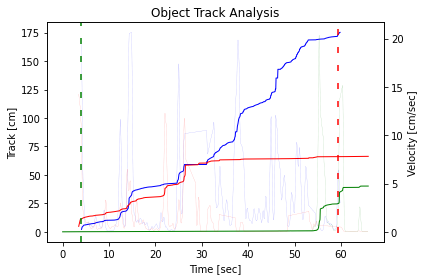

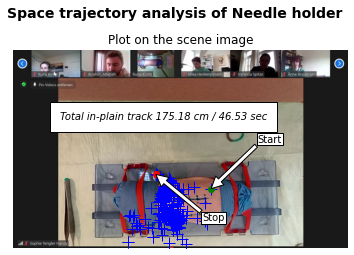

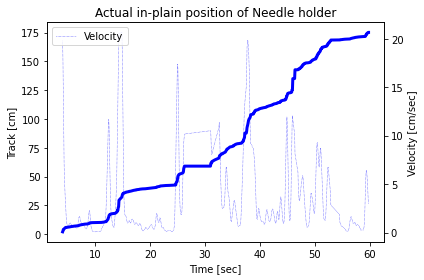

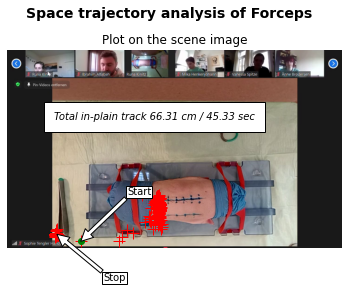

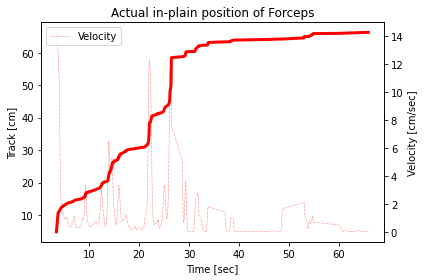

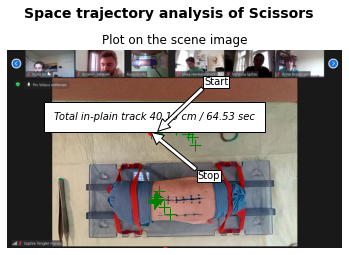

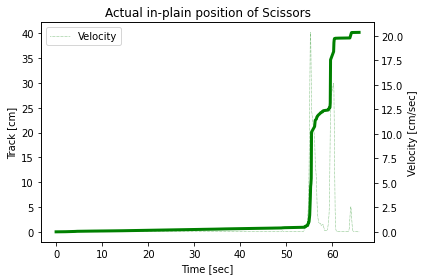

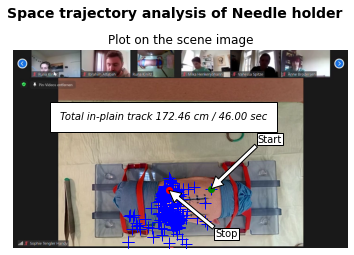

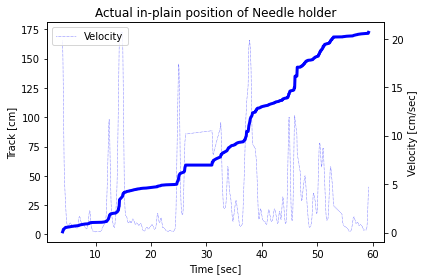

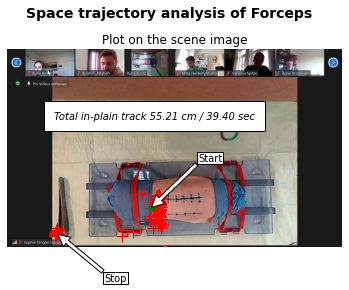

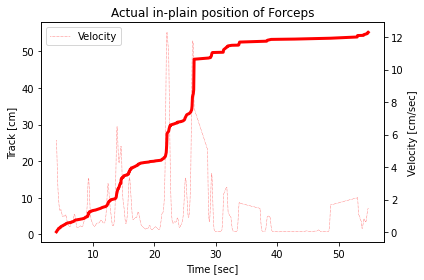

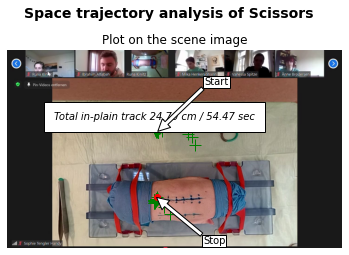

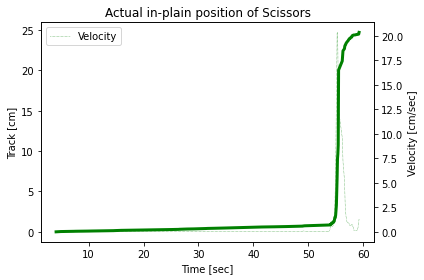

In [16]:
dcv = pigleg_cv.DoComputerVision(
    mediafile_path,
    outputdir,
    test_first_seconds=test_first_seconds,
    is_microsurgery=is_microsurgery,
    force_tracker=force_tracker
)
dcv.run()

In [17]:
logger

<loguru.logger handlers=[]>

In [18]:
from loguru import logger
logger.debug("ahoj")

In [19]:
logger.warning("asdf")

In [20]:
# report_data = dcv.make_report()